## BiLSTM을 이용한 개체명 인식(Named Entity Recognition, NER)
양방향 LSTM을 이용하여 개체명 인식기를 만든 후에 F1-score를 사용하여 모델을 평가합니다.

### 1. 개체명 인식 데이터에 대한 이해와 전처리
앞서 사용한 데이터와는 다른 데이터를 사용하여 개체명 인식을 수행해보겠습니다. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

2022-04-08 16:31:03.631727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-08 16:31:03.631769: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### 1) 데이터 로드하기
데이터는 아래의 링크에서 다운로드합니다.

링크 : https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

In [2]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20Sequence%20Labeling/dataset/ner_dataset.csv", filename="data/ner_data/ner_dataset.csv")
data = pd.read_csv("data/ner_data/ner_dataset.csv", encoding="latin1")

5개만  출력해보겠습니다.

In [3]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


데이터의 형식을 이해해봅시다. 첫번째 열 'Sentence :#'은 다음과 같은 패턴을 가지고 있습니다. Sentence: 1이 등장하고 Null 값이 이어지다가 다시 Sentence: 2가 등장하고 다시 Null 값이 이어지다가 Sentence: 3이 등장하고 다시 Null 값이 이어지다가를 반복합니다.  
  
사실 이는 하나의 문장을 여러 행으로 나눠놓은 것입니다. 숫자값을 t라고 합시다. 첫번째 Sentence: t부터 Null 값이 나오다가 Sentence: t+1이 나오기 전까지의 모든 행은 기존에 하나의 문장이었습니다. t번째 문장을 단어 토큰화 후 각 행으로 나눠놓은 데이터이기 때문입니다.  

뒤에서 Pandas의 fillna를 통해 하나로 묶는 작업을 해줍니다.

In [4]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


#### 2) 데이터 정제하기


현재 data의 행의 개수는 1,048,575개입니다. 하지만 뒤에서 문장 1개를 다수의 행들으로 나누어 놓은 것을 다시 1개의 행으로 병합하는 작업을 해야하기 때문에 최종 샘플의 개수는 이보다 줄어들게 됩니다.
  
결측값 유무를 살펴봅시다.

In [5]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


Sentence #열에 Null 값들이 존재하고 있어 isnull().values.any()를 수행하였을 때 True가 나옵니다. isnull().sum()을 수행하면 각 열마다의 Null 값의 개수를 보여줍니다.

In [6]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

다른 열은 0개인데 오직 Sentences #열에서만 1,000,616개가 나온 것을 볼 수 있습니다.  
  
전체 데이터에서 중복을 허용하지 않고 유일한 값의 개수를 셀 수 있게 해주는 nunique()를 사용해봅시다.

In [7]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


이 데이터에는 47,959개의 문장이 있으며 문장들은 35,178개의 단어를 가지고 17개 종류의 개체명 태깅을 가집니다.  
  
17개의 개체명 태깅이 전체 데이터에서 몇 개가 있는지, 개체명 태깅 개수의 분포를 확인해보도록 하겠습니다.

In [8]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


BIO 표현 방법에서 아무런 태깅도 의미하지 않는 O가 가장 887,908개로 가장 많은 개수를 차지함을 볼 수 있습니다.  
  
데이터를 원하는 형태로 가공해보겠습니다. 우선 Null 값을 제거합니다.  
Pandas의 fillna(method='ffill')는 Null 값을 가진 행의 바로 앞의 행의 값으로 Null 값을 채우는 작업을 수행합니다. t번째 문장에 속하면서 Null 값을 가진 샘플들은 전부 첫번째 열에 Sentence: t의 값이 들어갑니다. 이번에는 뒤의 5개의 샘플을 출력해서 정상적으로 수행되었는지 확인해봅시다.

In [9]:
data = data.fillna(method="ffill")
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


뒤의 5개 샘플의 첫번째 열이 Sentence: 47959로 채워졌습니다.  
이는 47,959번째 문장임을 의미하며, Null 값을 가진 행들의 바로 앞 행의 Sentence # 열의 값이 Sentence: 47959이었음을 의미합니다.  
  
전체 데이터에 Null 값이 존재하는지 확인해봅시다.

In [10]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


없는 것으로 나옵니다.  
  
모든 단어를 소문자화하여 단어의 개수를 줄여보겠습니다.

In [11]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


정상적으로 소문자화가 되었는지 앞의 샘플 5개만 출력해보겠습니다.

In [12]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍(pair)으로 묶는 작업을 수행합니다.

In [13]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


1,000,616개의 행의 개수가 각 문장당 하나의 샘플로 묶이면서 47,959개의 샘플이 되었습니다.  

정상적으로 수행되었는지 첫번째 샘플을 출력해봅시다.

In [14]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


전처리가 수행된 첫번째 샘플이 출력됩니다. 이러한 샘플이 총 47,959개가 있습니다. 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리시켜야 합니다. 즉, [('thousands', 'O'), ('of', 'O')]와 같은 문장 샘플이 있다면 thousands와 of는 같이 저장하고, O와 O를 같이 저장할 필요가 있습니다.  

동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 하는 zip()을 사용하여 단어와 개체명 태깅 정보를 분리해봅시다.

In [15]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.

    # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentence, tag_info = zip(*tagged_sentence) 
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

각 문장 샘플에서 단어는 sentences에 태깅 정보는 ner_tags에 저장하였습니다.  

임의로 첫번째 문장 샘플을 출력해보겠습니다.

In [16]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


첫번째 샘플에 대해서 단어에 대해서만 sentences[0]에, 또한 개체명에 대해서만 ner_tags[0]에 저장된 것을 볼 수 있습니다. 뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 ner_tags는 예측 대상인 y에 해당됩니다.  

다른 샘플들에 대해서도 처리가 되었는지 확인하기 위해 임의로 98번 인덱스의 샘플에 대해서도 확인해보겠습니다.

In [17]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


단어에 대해서만 sentences[98]에, 또한 개체명에 대해서만 ner_tags[98]에 저장된 것을 확인할 수 있습니다. 또한 첫번째 샘플과 길이가 다릅니다. 47,959개의 문장 샘플의 길이는 서로 다를 수 있습니다.  


#### 3) 정수 인코딩

전체 데이터의 길이 분포를 확인해봅시다.  

샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


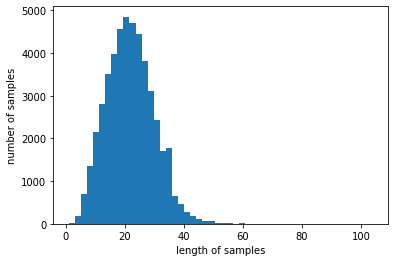

In [18]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프는 샘플들의 길이가 대체적으로 0~40의 길이를 가지는 것을 보여줍니다. 길이가 가장 긴 샘플의 길이는 104입니다.  

케라스 토크나이저를 통해서 정수 인코딩을 진행합니다. 이번에는 문장 데이터에 있는 모든 단어를 사용하겠습니다.  
토크나이저를 초기화 합니다.

In [19]:
# 모든 단어를 사용하며 인덱스 1에는 단어 'OOV'를 할당.
src_tokenizer = Tokenizer(oov_token='OOV')
# 태깅 정보들은 내부적으로 대문자를 유지한 채 저장
tar_tokenizer = Tokenizer(lower=False)

문장 데이터에 있는 모든 단어를 사용합니다

In [20]:
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer.fit_on_texts(ner_tags)

문장 데이터에 대해서는 src_tokenizer를, 레이블에 해당되는 개체명 태깅 정보에 대해서는 tar_tokenizer를 사용합니다.

In [21]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


앞서 src_tokenizer를 만들때 Tokenizer의 인자로 oov_token='OOV'를 선택했습니다. 인덱스1에 단어 'OOV'가 할당됩니다.

In [22]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


정수 인코딩을 수행합니다.

In [23]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

문장 데이터에 대해서 정수 인코딩이 수행된 결과는 X_data, 개체명 태깅 데이터에 대해서 정수 인코딩이 수행된 결과는 y_data에 저장되었습니다.

정수 인코딩이 되었는지 확인을 위해 임의로 2번 인덱스 샘플을 출력해보겠습니다.

In [24]:
print(X_data[:2])
print(y_data[:2])

[[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3], [327, 36, 27, 48, 1773, 7, 766, 1005, 7, 4424, 3184, 771, 6, 2, 1165, 84, 4, 43, 25, 1650, 2189, 454, 2190, 6016, 3]]
[[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1], [8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1]]


모델 훈련 후 결과 확인을 위해 인덱스로부터 단어를 리턴하는 index_to_word와 인덱스로부터 개체명 태깅 정보를 리턴하는 index_to_ner를 만듭니다.  

인덱스 0은 'PAD'란 단어를 할당해둡니다. index_to_ner은 개수가 적으니 출력해봅시다.

In [25]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


index_to_word를 통해 첫번째 샘플의 정수 시퀀스를 텍스트 시퀀스로 변환하는 디코딩 작업을 해보겠습니다.

In [26]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


X 데이터와 y 데이터가 구성되었습니다. 

#### 4) 패딩
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 앞서 확인하였듯이 대부분의 데이터의 길이는 40~60에 분포되어져 있습니다. 그러므로 가장 긴 샘플의 길이인 104가 아니라 70정도로 max_len을 정해보겠습니다. X에 해당되는 데이터 X_data의 샘플들과 y에 해당되는 데이터 y_data 샘플들의 모든 길이를 임의로 70정도로 맞추어 보겠습니다.  

케라스의 pad_sequences()를 사용합니다.

In [27]:
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

모든 샘플의 길이가 70이 되었습니다. 

#### 5) 학습데이터와 테스트 데이터 분리
사이킷런(scikit-learn)의 model_selection 패키지 안에 train_test_split 모듈을 활용하여 손쉽게 train set(학습 데이터 셋)과 test set(테스트 셋)을 분리할 수 있습니다.  

훈련 데이터와 테스트 데이터를 8:2의 비율로 분리합니다.
  
**옵션 값 설명**
 - test_size: 테스트 셋 구성의 비율을 나타냅니다. train_size의 옵션과 반대 관계에 있는 옵션 값이며, 주로 test_size를 지정해 줍니다. 0.2는 전체 데이터 셋의 20%를 test (validation) 셋으로 지정하겠다는 의미입니다. default 값은 0.25 입니다.
 - shuffle: default=True 입니다. split을 해주기 이전에 섞을건지 여부입니다. 보통은 default 값으로 놔둡니다.
 - stratify: default=None 입니다. classification을 다룰 때 매우 중요한 옵션값입니다. stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 줍니다. (한 쪽에 쏠려서 분배되는 것을 방지합니다) 만약 이 옵션을 지정해 주지 않고 classification 문제를 다룬다면, 성능의 차이가 많이 날 수 있습니다.
 - random_state: 세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있습니다.

In [28]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)

정답 레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행합니다. 케라스는 정수 인코딩 된 결과로부터 원-핫 인코딩을 수행하는 to_categorical()를 지원합니다.

In [29]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

각 데이터 크기를 확인해보겠습니다.

In [30]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


### 2. 양방향 LSTM을 이용한 개체명 인식
하이퍼파라미터인 임베딩 벡터의 차원은 128, 은닉 상태의 크기는 256입니다. 모델은 다 대 다 구조의 양방향 LSTM을 사용합니다. 이 경우 LSTM의 return_sequences의 인자값은 True로 주어야만 합니다. 이번 실습과 같이 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아질 경우에는 Embedding()에 mask_zero=True를 설정하여 숫자 0은 연산에서 제외시킨다는 옵션을 줄 수 있습니다. 출력층에 TimeDistributed()를 사용했는데, TimeDistributed()는 LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용할 필요가 있을 때 사용합니다.

해당 모델은 모든 시점에 대해서 개체명 레이블 개수만큼의 선택지 중 하나를 예측하는 다중 클래스 분류 문제를 수행하는 모델입니다. 다중 클래스 분류 문제의 경우, 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용합니다. 하이퍼파라미터인 배치 크기는 128이며, 6 에포크를 수행합니다. validation_split=0.1을 사용하여 훈련 데이터의 10%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

2022-04-08 16:32:49.572562: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-08 16:32:49.572598: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 16:32:49.572613: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-41K4BMT): /proc/driver/nvidia/version does not exist
2022-04-08 16:32:49.575625: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/6
270/270 [==============================] - 76s 268ms/step - loss: 0.1722 - accuracy: 0.8763 - val_loss: 0.0765 - val_accuracy: 0.9327
Epoch 2/6
270/270 [==============================] - 73s 270ms/step - loss: 0.0538 - accuracy: 0.9504 - val_loss: 0.0480 - val_accuracy: 0.9543
Epoch 3/6
270/270 [==============================] - 72s 268ms/step - loss: 0.0368 - accuracy: 0.9647 - val_loss: 0.0448 - val_accuracy: 0.9573
Epoch 4/6
270/270 [==============================] - 72s 268ms/step - loss: 0.0299 - accuracy: 0.9704 - val_loss: 0.0428 - val_accuracy: 0.9587
Epoch 5/6
270/270 [==============================] - 72s 267ms/step - loss: 0.0259 - accuracy: 0.9740 - val_loss: 0.0441 - val_accuracy: 0.9588
Epoch 6/6
270/270 [==============================] - 72s 268ms/step - loss: 0.0228 - accuracy: 0.9766 - val_loss: 0.0452 - val_accuracy: 0.9579


총 6번의 에포크를 마치고나서 val_accuracy: 0.9586 검증 데이터에 대해서 약 95%의 정확도를 얻습니다.  

테스트 데이터의 임의의 인덱스 13번 샘플에 대해서 실제값과 예측값을 비교해봅시다.

In [32]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


정확하게 예측했습니다. 

F1-score라는 성능 평가 방법에 대해서 이해하고, 테스트 데이터에 대해서 성능을 측정해봅시다.

### 3. F1-score
개체명 인식에서는 그 어떤 개체도 아니라는 의미의 'O'라는 태깅이 존재합니다. 그런데 이런 정보는 보통 대다수의 레이블을 차지하기 때문에 기존에 사용했던 정확도(accuracy)를 평가 방법으로 사용하는 것이 적절하지 않을 수 있습니다.

예를 들어 모델이 단 1개의 개체도 맞추지 못하고 전부 'O'로 예상했을 경우를 봅시다. 실제값은 위에서 출력했던 값을 실제값으로 재사용하겠습니다. 아래 코드에서는 labels라는 변수에 저장하였습니다. 그리고 개체를 하나도 맞추지 못했다는 가정하에 전부 'O'로만 채워진 예측값 predicted를 생성합니다.

In [33]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['O'] * len(labels) 
print('예측값 :',predicted)

예측값 : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


실제로는 PER, MISC, PER, MISC, PER이라는 총 5개의 개체가 존재함에도 불구하고 예측값인 predicted는 단 1개의 개체도 맞추지 못한 상황을 시뮬레이션하는 것입니다. 이에 대한 정확도를 계산해봅시다.

In [34]:
hit = 0 # 정답 개수
for tag, pred in zip(labels, predicted):
    if tag == pred:
        hit +=1 # 정답인 경우에만 +1
accuracy = hit/len(labels) # 정답 개수를 총 개수로 나눈다.
print("정확도: {:.1%}".format(accuracy))

정확도: 74.4%


실제값에서도 대부분의 값이 'O'이기 때문에 그 어떤 개체도 찾지 못하였음에도 74%의 정확도를 얻습니다. 이는 정확도가 뻥튀기되어 모델의 성능을 오해할 수 있다는 문제가 있습니다. 그래서 여기서는 위와 같은 상황에서 더 적절한 평가 방법을 도입하고자 합니다. 

앞서 머신 러닝 훑어보기 챕터에서 정밀도(precision)과 재현률(recall)을 언급한 바 있습니다. 개체명 인식 모델의 성능 측정을 위해 정밀도와 재현률 개념을 사용해보겠습니다. 이를 개체명 인식 문제에 맞도록 해석해보면 다음과 같습니다.

정밀도 $ = \frac{TP}{TP + FP} = $ 특정 개체라고 예측한 경우중에서 실제 특정 개체로 판명되어 예측이 일치한 비율  
참, 거짓 포함 포함해서 맞춘 것들중 참인것으로 맞춘 비율

재현률 $ = \frac{TP}{TP + FN} = $ 전체 특정 개체중에서 실제 특정 개체라고 정답을 맞춘 비율  
참, 거짓 포함, 원래 정답인 것들 중에서 참인것으로 맞춘 비율

정밀도와 재현률로부터 조화 평균(harmonic mean)을 구한 것을 f1-score라고 합니다.

$$f1-score = 2×\frac{정밀도×재현률}{정밀도＋재현률}$$
 
predicted의 성능을 평가하기 위해서 정밀도, 재현률, f1-score를 계산해보도록 하겠습니다.

In [35]:
from seqeval.metrics import classification_report
print(classification_report([labels], [predicted]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



/mnt/c/PJT/000NLP/nlp_env/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/PJT/000NLP/nlp_env/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


이러한 측정 방법을 사용하면 PER과 MISC 두 특정 개체 중에서 실제 predicted가 맞춘 것은 단 1개도 없는 것을 확인할 수 있습니다. 이번에는 어느 정도는 정답을 맞추었다고 가정하고 예측값인 predicted를 수정하여 정밀도, 재현률, f1-score를 확인해봅시다.

In [36]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']

print(classification_report([labels], [predicted]))

              precision    recall  f1-score   support

        MISC       1.00      0.50      0.67         2
         PER       1.00      0.67      0.80         3

   micro avg       1.00      0.60      0.75         5
   macro avg       1.00      0.58      0.73         5
weighted avg       1.00      0.60      0.75         5



특정 개체로 예측한 경우에 대해서는 모두 제대로 예측을 하였으므로 정밀도는 1이 나옵니다. 하지만 재현률에서는 MISC는 실제로는 4개임에도 2개만을 맞추었으므로 0.5, PER은 실제로는 3개임에도 2개만을 맞추었으므로 0.67이 나온 것을 볼 수 있습니다.

### 4. F1-score로 성능 측정하기
F1-score를 계산하기 위해서 개체명 태깅의 확률 벡터 또는 원-핫 벡터로부터 태깅 정보 시퀀스로 변환하는 함수인 sequences_to_tag를 만듭니다. 해당 함수를 통해 모델의 예측값인 y_predicted와 실제값에 해당하는 y_test를 태깅 정보 시퀀스로 변환합니다. 그리고 두 개를 비교하여 f1-score를 계산합니다.

In [37]:
from seqeval.metrics import f1_score, classification_report

def sequences_to_tag(sequences):
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences:
        word_sequence = []
        # 시퀀스로부터 확률 벡터 또는 원-핫 벡터를 하나씩 꺼낸다.
        for pred in sequence:
            # 정수로 변환. 예를 들어 pred가 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = np.argmax(pred)            
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

F1-score: 78.1%
              precision    recall  f1-score   support

         art       0.13      0.03      0.05        63
         eve       0.57      0.25      0.35        52
         geo       0.81      0.86      0.83      7620
         gpe       0.96      0.94      0.95      3145
         nat       0.47      0.19      0.27        37
         org       0.57      0.57      0.57      4033
         per       0.71      0.69      0.70      3545
         tim       0.85      0.83      0.84      4067

   micro avg       0.78      0.78      0.78     22562
   macro avg       0.63      0.55      0.57     22562
weighted avg       0.78      0.78      0.78     22562

